# Loan Default Prediction - Part 02 - Binary Classification with Logistic Regression

This is an exploratory project for me to apply what I have learned in the Data Science and Machine Learning courses that I took this year. The data is from a Kaggle competition [Loan Default Prediction](https://www.kaggle.com/c/loan-default-prediction). 

This is Part 02 of the project: Binary Classification with Logistic Regression.

## As a Classification Problem

The target column __loss__ from the provided data indicates the percentage of loan unpaid for. The values of __loss__ range from 0 to 100. A regression model is required to predict __loss__. Before trying it, I will first attempt at a simpler problem. Instead of regression, I change the problem to a binary classification problem. I set the label to be 1 if __loss__ is greater than 0 and set it to 0 otherwise.

In [1]:
# Import libraries

import numpy as np
import pandas as pd

In [2]:
# Load the training data (imputed but not normalized) from the CSV file

def load_csv(file, describe=False):
    df = pd.read_csv(file, na_values='NA')
    df = df.drop(['id', 'Unnamed: 0'], axis=1) # Dropping the ID column
    
    # Display basic information
    df.info()
    if describe:
        print(df.describe(include='all'))

    # Separate features and labels
    X = df.drop(['loss'], axis=1) # Features
    y = (df.loc[:,'loss'] > 0) # Labels
    if describe:
        print(X.shape, y.shape)
    
    return df, X, y
        
df, X, y = load_csv('train_v2_preprocessed.csv', describe=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f1_0 to loss
dtypes: float64(1789)
memory usage: 1.4 GB
                f1_0           f1_1           f1_2           f1_3  \
count  105471.000000  105471.000000  105471.000000  105471.000000   
mean        0.000284       0.000076       0.000294       0.000218   
std         0.016863       0.008709       0.017142       0.014766   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

                f1_4           f1_5           f1_6           f1_7  \
count  105471.000000  105471.000000  105471.000000  105471.000000   
mean        0.001185       0.000578       0.002266       0.002579   
std         0.

## Training and Validation Data

I split the data into the training and validation sets using the [sklearn.model_selection.KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). If setting the __shuffle__ option to be False, KFold makes __k__ splits in a deterministic way. The first split assigns the first 1/k rows of data as the validation set, and the rest as the training set. The second assigns the second 1/k rows as the validation set, and the rest as the training set, and so on. For now, I set the __shuffle__ option to be __False__ in order to get the same training and testing sets for each experiment. Although I do not know if the data is distributed evenly -- if not, my training and testing sets would follow different distributions -- I can compare the results from different experiments more fairly this way.

In [3]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
splits = list(kf.split(X))
train_index, valid_index = splits[0] # Take the first split only
print("Training set: ", train_index)
print("Validation set: ", valid_index)

Training set:  [ 21095  21096  21097 ... 105468 105469 105470]
Validation set:  [    0     1     2 ... 21092 21093 21094]


In [4]:
X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

## Logistic Regression (Vanilla Version)

I will first try the most basic version of logistic regression, using the [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) package. Here, I am using all default values when instantiating and fitting the LogisticRegression model. Let's see how it does. I will also be timing the fitting process.

In [5]:
from sklearn import linear_model
import time

def train_model(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    fit_time = end - start
    print('Time elapsed (Training): %.4f s' % fit_time)
    print(clf)

clf=linear_model.LogisticRegression()
train_model(clf, X_train, y_train)

Time elapsed (Training): 144.7139 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Metrics

I use 3 metrics to evaluate the quality of the model.

(1) __Accuracy__: The fraction of correct predictions.
(2) __ROCAUC__: The area under the ROC curve (plotting true positive rates against false positive rates at various threshold settings). 
(3) __PRAUC__: The area under the precision-recall curve.

(2) and (3) require the model to provide the predicted probabilty of each class. They indicate how well the model is doing in terms of ranking the objects. 

In [6]:
# Define the evaluate function

from sklearn import metrics
import matplotlib.pyplot as plt

def evaluate (clf, X_train, y_train, X_valid, y_valid):
    # Plotting ROCAUC and PRAUC
    f, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))        
    plt1.set_title('ROC Curve')
    plt1.set_xlabel('FPR')
    plt1.set_ylabel('TPR')
    plt2.set_title('PR Curve')
    plt2.set_xlabel('Precision')
    plt2.set_ylabel('Recall')

    start = time.time()
    
    # Training set    
    y_train_predicted = clf.predict_proba(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_train_predicted[:,1])
    plt1.scatter(fpr, tpr, color='b')    
    plt2.scatter(precision, recall,color='b')
    print('Accuracy (Training): %f' % clf.score(X_train, y_train))
    print('ROCAUC Score (Training): %f' % metrics.roc_auc_score(y_train, y_train_predicted[:,1]))
    print('PRAUC Score (Training): %f' % metrics.auc(precision, recall, reorder=True))

    # Validation set
    y_valid_predicted = clf.predict_proba(X_valid)    
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_valid_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_valid_predicted[:,1])
    plt1.scatter(fpr, tpr, color='r')
    plt2.scatter(precision, recall,color='r')
    print('Accuracy (Validation): %f' % clf.score(X_valid, y_valid))
    print('ROCAUC Score (Validation): %f' % metrics.roc_auc_score(y_valid, y_valid_predicted[:,1]))
    print('PRAUC Score (Validation): %f' % metrics.auc(precision, recall, reorder=True))
    
    end = time.time()
    eval_time = end - start
    print('Time elapsed (Evaluation): %.4f s' % eval_time)

    plt.show()
    plt.close()

Accuracy (Training): 0.903657
ROCAUC Score (Training): 0.435150
PRAUC Score (Training): 0.015330
Accuracy (Validation): 0.910642
ROCAUC Score (Validation): 0.448502
PRAUC Score (Validation): 0.012742
Time elapsed (Evaluation): 1.3486 s


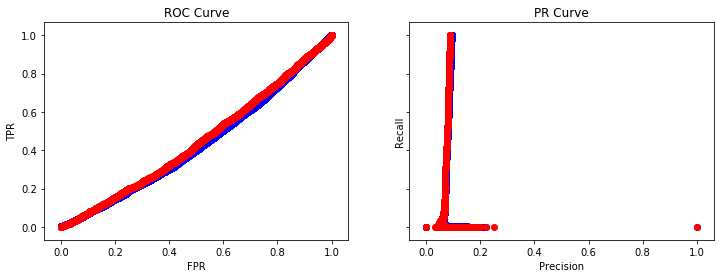

In [7]:
evaluate(clf, X_train, y_train, X_valid, y_valid)

The accuracy is > 90%, which doesn't seem too bad. However, ROCAUC < 0.5 indicates that the model performs worse than random guessing. Why is the ROCAUC bad while the accuracy is good? Let's take a look at the distribution of the labels.

In [8]:
# Count the number of positive and negative labels, respectively

n_pos = sum(1 if (yy == 1) else 0 for yy in y)
n_neg = sum(1 if (yy == 0) else 0 for yy in y)
print("Number of pos labels: %d" % n_pos)
print("Number of neg labels: %d" % n_neg)
print("Pos ratio = %f" % (n_pos/(n_pos + n_neg)))
print("Neg ratio = %f" % (n_neg/(n_pos + n_neg)))

Number of pos labels: 9783
Number of neg labels: 95688
Pos ratio = 0.092755
Neg ratio = 0.907245


## Adding Class Weights

It turns out the numbers of negative labels is 10 times those of negative labels, which is quite unbalanced. Even if the classification model predicts all 0s, the accuracy would still be around 0.9. The model would also potentially be biased towards the negative examples, which are the majority. To overcome this issue, I try to add different weights to positive and negative examples.

First, I will try assigning the positive and negative weights to be 10:1 such that the weighted number of postive and negative examples are approximately the same.

Time elapsed (Training): 57.2628 s
LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.175358
ROCAUC Score (Training): 0.573038
PRAUC Score (Training): 0.028617
Accuracy (Validation): 0.174923
ROCAUC Score (Validation): 0.554953
PRAUC Score (Validation): 0.024412
Time elapsed (Evaluation): 1.4185 s


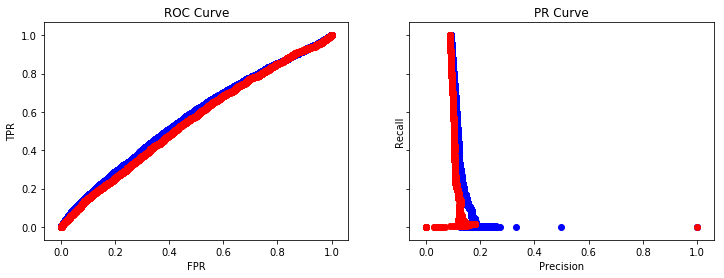

In [9]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 10.}
clf=linear_model.LogisticRegression(class_weight=class_weight)
train_model(clf, X_train, y_train)
evaluate(clf, X_train, y_train, X_valid, y_valid)

Now, the accuracy drops to 20%, but the ROCAUC improves from 0.448 to 0.556 (validation), indicating higher quality of the model. Moreover, the difference between the metrics measured from the training set and and those from the validation set is small, which means overfitting isn't likely problem.

I'll try some different weights and see the effect.

Time elapsed (Training): 185.5069 s
LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 3.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.899972
ROCAUC Score (Training): 0.440986
PRAUC Score (Training): 0.018701
Accuracy (Validation): 0.911496
ROCAUC Score (Validation): 0.449114
PRAUC Score (Validation): 0.467181
Time elapsed (Evaluation): 1.4235 s


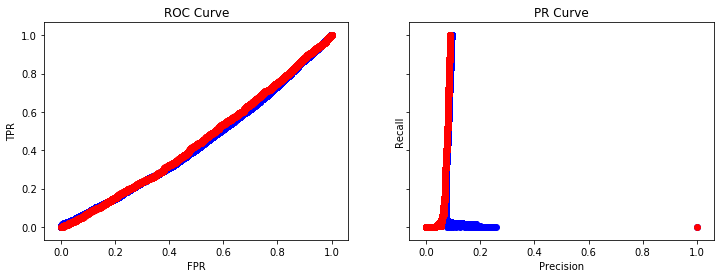

In [10]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 3.}
clf=linear_model.LogisticRegression(class_weight=class_weight)
train_model(clf, X_train, y_train)
evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 157.4019 s
LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 20.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.094446
ROCAUC Score (Training): 0.569134
PRAUC Score (Training): 0.071559
Accuracy (Validation): 0.088741
ROCAUC Score (Validation): 0.553523
PRAUC Score (Validation): 0.026346
Time elapsed (Evaluation): 1.3706 s


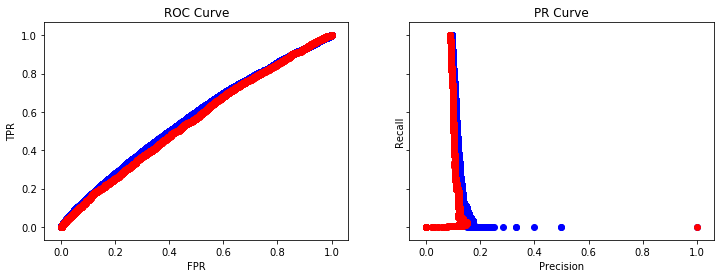

In [11]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 20.}
clf=linear_model.LogisticRegression(class_weight=class_weight)
train_model(clf, X_train, y_train)
evaluate(clf, X_train, y_train, X_valid, y_valid)

We can see that giving the positive examples a weight at least 10 times greater than that of the negative examples help the model perform better.

## Normalized Data

Logistic Regression is one of the models that can be sensitive to the magnitude of data. To see the effect of normalization, I prepared a normalized version of the data in Part 01. I will now load this version, fit the model, and compare with the results above.

In [12]:
# Load the training data (imputed but not normalized) from the CSV file

df, X, y = load_csv('train_v2_preprocessed_normalized.csv', describe=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1789)
memory usage: 1.4 GB
                 f3            f6            f7            f8            f9  \
count  1.054710e+05  1.054710e+05  1.054710e+05  1.054710e+05  1.054710e+05   
mean   6.371538e-17 -2.551310e-15  8.616015e-17  6.933486e-17  1.133843e-15   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   
min   -1.728340e+00 -1.345229e+00 -1.165221e+00 -1.075084e+00 -2.006220e+00   
25%   -8.662007e-01 -1.029760e+00 -9.206516e-01 -7.467748e-01 -7.425324e-01   
50%   -2.767762e-03  7.998521e-01 -2.685968e-01 -2.872299e-01 -4.408965e-01   
75%    8.672785e-01  9.008977e-01  6.692472e-01  4.305880e-01  1.050646e+00   
max    1.734808e+00  1.137185e+00  2.747500e+00  4.024096e+00  2.777276e+00   

                f10           f14           f15           f16           f17  \
count  1.054710e+05  1.054710e+05  1.054710e+05  1.054

In [13]:
# Separate training and validation sets

def split_data(kf, X, y, describe=False):
    splits = list(kf.split(X))
    train_index, valid_index = splits[0] # Take the first split only    
    if describe:
        print("Training set: ", train_index)
        print("Validation set: ", valid_index)        
    
    X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    return X, y, X_train, y_train, X_valid, y_valid

X, y, X_train, y_train, X_valid, y_valid = split_data(kf, X, y)

First, I try fitting the model without class weights.

Time elapsed (Training): 386.4259 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906040
ROCAUC Score (Training): 0.746871
PRAUC Score (Training): 0.132637
Accuracy (Validation): 0.911116
ROCAUC Score (Validation): 0.709011
PRAUC Score (Validation): 0.090800
Time elapsed (Evaluation): 0.9667 s


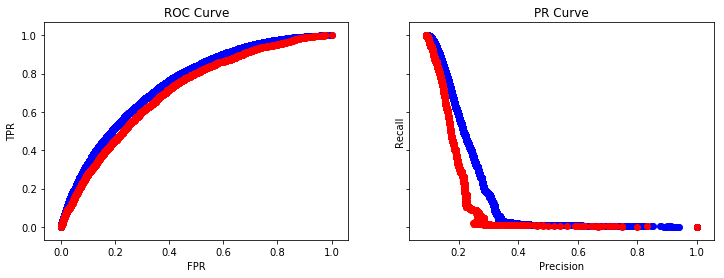

In [14]:
clf=linear_model.LogisticRegression()
train_model(clf, X_train, y_train)
evaluate(clf, X_train, y_train, X_valid, y_valid)

There is significant improvement over the previous attempts. The ROCAUC is 0.75 for the training set and 0.71 for the validation set. The accuracy remains high, > 0.9. There is a slight discrepancy between the results from the training and the validation sets, but this is a great start. This illustrates how important it is to use normalized data when fitting a logistic regression model.

Next, I try a few different class weights.

Time elapsed (Training): 289.6391 s
LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.655992
ROCAUC Score (Training): 0.748883
PRAUC Score (Training): 0.121260
Accuracy (Validation): 0.643802
ROCAUC Score (Validation): 0.710034
PRAUC Score (Validation): 0.092892
Time elapsed (Evaluation): 0.8887 s


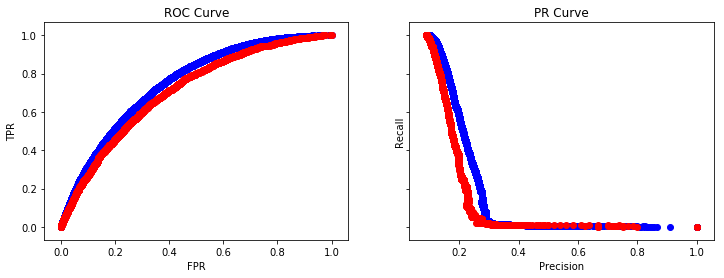

In [15]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 10.}
clf=linear_model.LogisticRegression(class_weight=class_weight)
train_model(clf, X_train, y_train)
evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 476.0863 s
LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 3.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.883675
ROCAUC Score (Training): 0.750583
PRAUC Score (Training): 0.129997
Accuracy (Validation): 0.881678
ROCAUC Score (Validation): 0.710334
PRAUC Score (Validation): 0.092353
Time elapsed (Evaluation): 0.9447 s


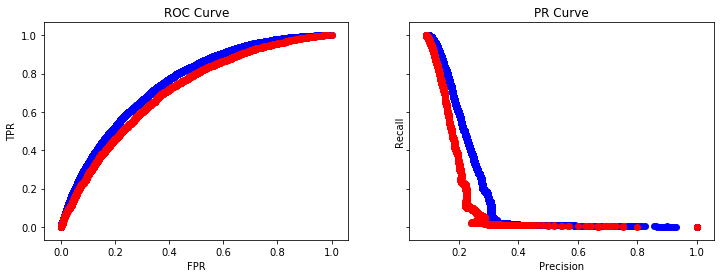

In [16]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 3.}
clf=linear_model.LogisticRegression(class_weight=class_weight)
train_model(clf, X_train, y_train)
evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 571.3382 s
LogisticRegression(C=1.0, class_weight={0: 1.0, 1: 20.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.445695
ROCAUC Score (Training): 0.749507
PRAUC Score (Training): 0.117872
Accuracy (Validation): 0.437307
ROCAUC Score (Validation): 0.708500
PRAUC Score (Validation): 0.092669
Time elapsed (Evaluation): 0.9327 s


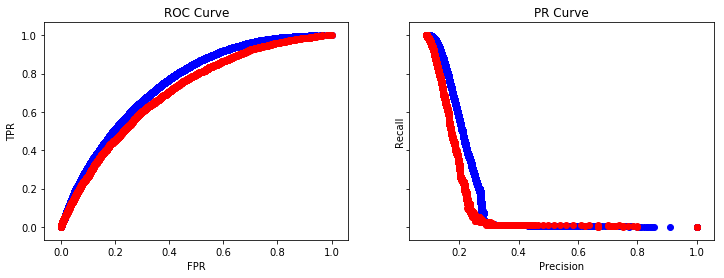

In [17]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 20.}
clf=linear_model.LogisticRegression(class_weight=class_weight)
train_model(clf, X_train, y_train)
evaluate(clf, X_train, y_train, X_valid, y_valid)

Surprisingly, there is not much difference in ROCAUC under different class weights. The accuracy also decreases as we increase the difference in class weights. In other words, class weights do not offer much help here. Therefore, I will not be assigning class weights in the next experiments.

## K-Fold Validation

Finally, I will perform K-Fold Validation with __k__=5.

Time elapsed (Training): 334.0689 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906040
ROCAUC Score (Training): 0.746871
PRAUC Score (Training): 0.132637
Accuracy (Validation): 0.911116
ROCAUC Score (Validation): 0.709011
PRAUC Score (Validation): 0.090800
Time elapsed (Evaluation): 0.9107 s


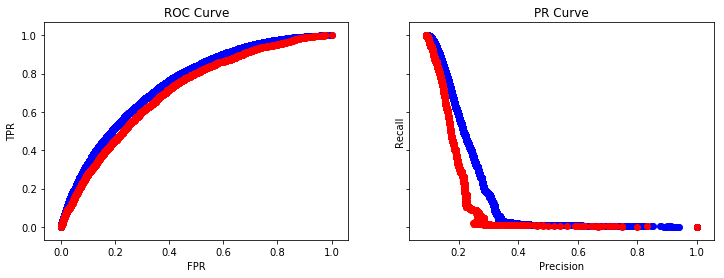

Time elapsed (Training): 252.4177 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906124
ROCAUC Score (Training): 0.745802
PRAUC Score (Training): 0.133120
Accuracy (Validation): 0.911681
ROCAUC Score (Validation): 0.710787
PRAUC Score (Validation): 0.089005
Time elapsed (Evaluation): 0.9697 s


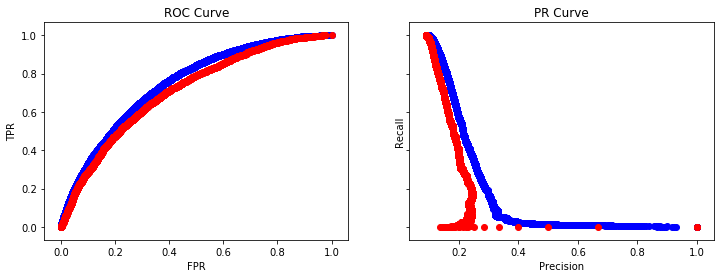

Time elapsed (Training): 230.0027 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.908103
ROCAUC Score (Training): 0.745371
PRAUC Score (Training): 0.128791
Accuracy (Validation): 0.902579
ROCAUC Score (Validation): 0.710267
PRAUC Score (Validation): 0.098556
Time elapsed (Evaluation): 0.9487 s


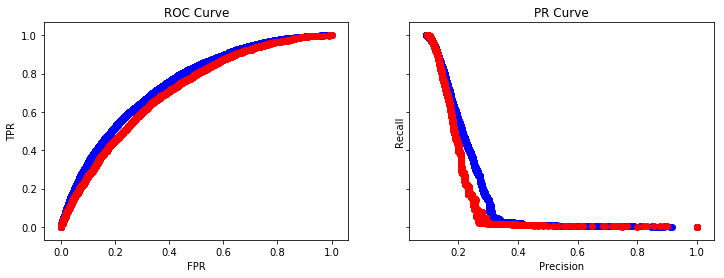

Time elapsed (Training): 259.2294 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.907143
ROCAUC Score (Training): 0.745957
PRAUC Score (Training): 0.132207
Accuracy (Validation): 0.906182
ROCAUC Score (Validation): 0.707577
PRAUC Score (Validation): 0.097419
Time elapsed (Evaluation): 0.9317 s


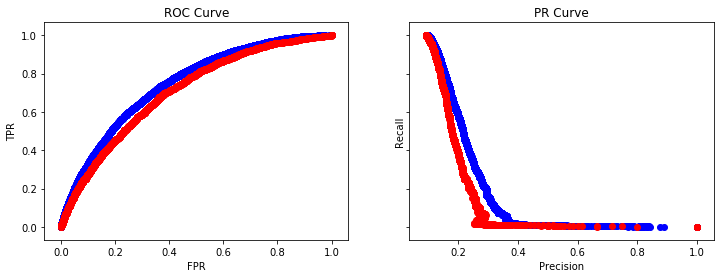

Time elapsed (Training): 260.1411 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.908850
ROCAUC Score (Training): 0.744307
PRAUC Score (Training): 0.130502
Accuracy (Validation): 0.900114
ROCAUC Score (Validation): 0.721784
PRAUC Score (Validation): 0.101445
Time elapsed (Evaluation): 0.9457 s


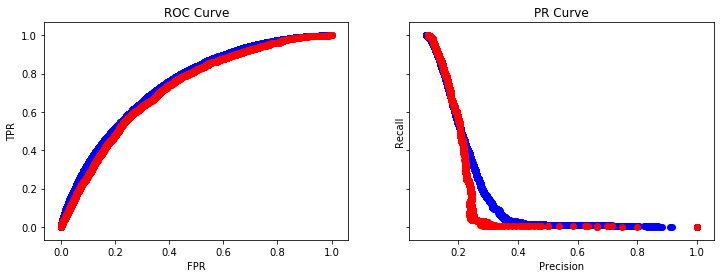

In [18]:
for train_index, valid_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    clf=linear_model.LogisticRegression()
    train_model(clf, X_train, y_train)
    evaluate(clf, X_train, y_train, X_valid, y_valid)

We can see that all __k__=5 splits yield similar results, which means that the dataset has a somewhat even distribution.